# Exploratory Data Analysis (EDA)

**Author:** Brendon McNulty  
**Date:** September 30, 2025  

**Purpose:**  
This notebook performs a custom exploratory data analysis project using Python, pandas, matplotlib, and seaborn. The goal is to explore a dataset, analyze its structure, and tell a data story through visualizations.


In [12]:
# Import required libraries for data analysis and visualization
import pandas as pd        # Data manipulation and analysis
import seaborn as sns      # Statistical data visualization
import matplotlib.pyplot as plt  # Core plotting library



## Data Processing: Create Slimmed Dataset

The raw dataset contains 165 columns with a wide variety of statistics.  
For this analysis, we want to focus on the most important efficiency metrics  
and reduce the dataset to something more manageable.  

Steps performed in the code below:
- Load the full dataset from `data/raw/march_madness_2002_2025.csv`  
- Filter the data to include only seasons **2015–2025**  
- Select the following columns:
  - `season` → Year of the season  
  - `conference` → NCAA conference (e.g., SEC, ACC, Big Ten)  
  - `adj_off_eff` → Adjusted Offensive Efficiency (points scored per 100 possessions)  
  - `adj_def_eff` → Adjusted Defensive Efficiency (points allowed per 100 possessions)  
  - `adj_tempo` → Adjusted Tempo (average possessions per game)  
- Create a new column `eff_diff` = `adj_off_eff - adj_def_eff` (net efficiency)  
- Save the slimmed dataset to `data/processed/march_madness_2015_2025.csv`  

This processed dataset will be used for the rest of the exploratory data analysis.


In [13]:
import pandas as pd
import re

RAW = "data/raw/march_madness_2002_2025.csv"
OUT = "data/processed/march_madness_2015_2025.csv"

df = pd.read_csv(RAW)
print("Full dataset shape:", df.shape)

cols = df.columns.tolist()
print("Total columns:", len(cols))

def pick(prefer_patterns, avoid_patterns=("rank", "raw")):
    """
    Return the FIRST column that matches any 'prefer_patterns' (regex, case-insensitive)
    while NOT matching any of the 'avoid_patterns'.
    """
    for pat in prefer_patterns:
        rx = re.compile(pat, re.IGNORECASE)
        for c in cols:
            if rx.search(c) and not any(re.search(ap, c, re.IGNORECASE) for ap in avoid_patterns):
                return c
    return None

# Hard preferences based on what you showed in screenshots
season_col = "Season" if "Season" in cols else None
conf_col   = "Short Conference Name" if "Short Conference Name" in cols else (
             "Conference" if "Conference" in cols else None)

# Prefer adjusted (not raw/rank); try specific names first, then fallbacks
off_col = pick([
    r"^pre[-\s]?tournament\.?adj\s*oe$",
    r"^adjusted\s*offensive\s*efficiency$",
    r"\badj\s*oe\b", r"\boe\b"
])

def_col = pick([
    r"^pre[-\s]?tournament\.?adj\s*de$",
    r"^adjusted\s*defensive\s*efficiency$",
    r"\badj\s*de\b", r"\bde\b"
])

tempo_col = pick([
    r"^pre[-\s]?tournament\.?adj\s*tempo$",
    r"^adjusted\s*tempo$",
    r"\badj\s*tempo\b", r"\btempo\b"
])

chosen = {
    "season": season_col,
    "conference": conf_col,
    "adj_off_eff": off_col,
    "adj_def_eff": def_col,
    "adj_tempo": tempo_col,
}
print("Chosen columns:", chosen)

# Basic sanity check
must_have = [season_col, conf_col, off_col, def_col, tempo_col]
if any(x is None for x in must_have):
    missing = [k for k, v in chosen.items() if v is None]
    raise ValueError(f"Could not locate columns for: {missing}. "
                     f"Open df.columns to inspect and adjust patterns.")

# Build slim dataframe
df_small = df.copy()

# Ensure Season numeric & filter recent
df_small[season_col] = pd.to_numeric(df_small[season_col], errors="coerce")
df_small = df_small[df_small[season_col] >= 2015].copy()

# Keep only the columns we need (in nice order)
df_small = df_small[[season_col, conf_col, off_col, def_col, tempo_col]].copy()

# Rename to tidy snake_case for analysis
df_small.rename(columns={
    season_col: "season",
    conf_col: "conference",
    off_col: "adj_off_eff",
    def_col: "adj_def_eff",
    tempo_col: "adj_tempo",
}, inplace=True)

# Add efficiency differential
df_small["eff_diff"] = df_small["adj_off_eff"] - df_small["adj_def_eff"]

# Save processed file
df_small.to_csv(OUT, index=False)
print("Slimmed dataset shape:", df_small.shape)
print("Saved:", OUT)

df_small.head()




Full dataset shape: (8315, 165)
Total columns: 165
Chosen columns: {'season': 'Season', 'conference': 'Short Conference Name', 'adj_off_eff': 'Pre-Tournament.AdjOE', 'adj_def_eff': 'Pre-Tournament.AdjDE', 'adj_tempo': 'Pre-Tournament.AdjTempo'}
Slimmed dataset shape: (3915, 6)
Saved: data/processed/march_madness_2015_2025.csv


,season,conference,adj_off_eff,adj_def_eff,adj_tempo,eff_diff
0,2025,ACC,127.954,89.7995,65.7242,38.1545
1,2015,SEC,121.270,83.8367,61.9696,37.4333
2,2025,B12,123.226,87.7815,61.4245,35.4445
3,2021,WCC,126.111,89.4872,74.7701,36.6238
4,2024,BE,126.609,94.3959,64.4531,32.2131


## Initial Data Inspection

In this step, we load the processed dataset (`march_madness_2015_2025.csv`)  
and take an initial look at its structure.  

We will:
- View the first 10 rows of the dataset  
- Check the number of rows and columns  
- Inspect the data types for each column  
- Generate basic descriptive statistics for numerical columns  


In [14]:
# Load the processed dataset
df = pd.read_csv("data/processed/march_madness_2015_2025.csv")

# Display first 10 rows
print("First 10 rows:")
print(df.head(10))

# Shape of the dataset
print("\nShape (rows, columns):", df.shape)

# Data types of each column
print("\nData types:")
print(df.dtypes)

# Summary statistics for numerical columns
print("\nSummary statistics:")
print(df.describe())



First 10 rows:
   season conference  adj_off_eff  adj_def_eff  adj_tempo  eff_diff
0    2025        ACC      127.954      89.7995    65.7242   38.1545
1    2015        SEC      121.270      83.8367    61.9696   37.4333
2    2025        B12      123.226      87.7815    61.4245   35.4445
3    2021        WCC      126.111      89.4872    74.7701   36.6238
4    2024         BE      126.609      94.3959    64.4531   32.2131
5    2025        SEC      128.600      92.4375    69.5882   36.1625
6    2025        SEC      128.426      93.3790    67.5825   35.0470
7    2019        ACC      123.571      87.9163    59.2665   35.6547
8    2021        B12      123.265      93.7679    68.3891   29.4971
9    2018         BE      127.384      95.9749    68.2770   31.4091

Shape (rows, columns): (3915, 6)

Data types:
season           int64
conference      object
adj_off_eff    float64
adj_def_eff    float64
adj_tempo      float64
eff_diff       float64
dtype: object

Summary statistics:
            seaso

## Initial Data Inspection Results

The slimmed dataset (`2015–2025`) contains the following key statistics:

- **Season** ranges from 2015 to 2025.  
- **Adjusted Offensive Efficiency (adj_off_eff)**: Avg ~105 points per 100 possessions, ranging from ~90 to ~128.  
- **Adjusted Defensive Efficiency (adj_def_eff)**: Avg ~104 points allowed per 100 possessions, ranging from ~87 to ~125.  
- **Adjusted Tempo (adj_tempo)**: Avg ~67 possessions per game, ranging from ~61 to ~82.  
- **Efficiency Difference (eff_diff)**: Balance of offense vs. defense, ranging from strongly negative (~-9) to strongly positive (~+38).  

These results confirm that the dataset is valid and contains meaningful variation across seasons and conferences, which will be useful for my exploratory analysis.


## Initial Data Distributions

To better understand the dataset, we will begin with simple histograms  
to visualize the distributions of the key numerical variables:

- Adjusted Offensive Efficiency (`adj_off_eff`)  
- Adjusted Defensive Efficiency (`adj_def_eff`)  
- Adjusted Tempo (`adj_tempo`)  
- Efficiency Difference (`eff_diff`)  


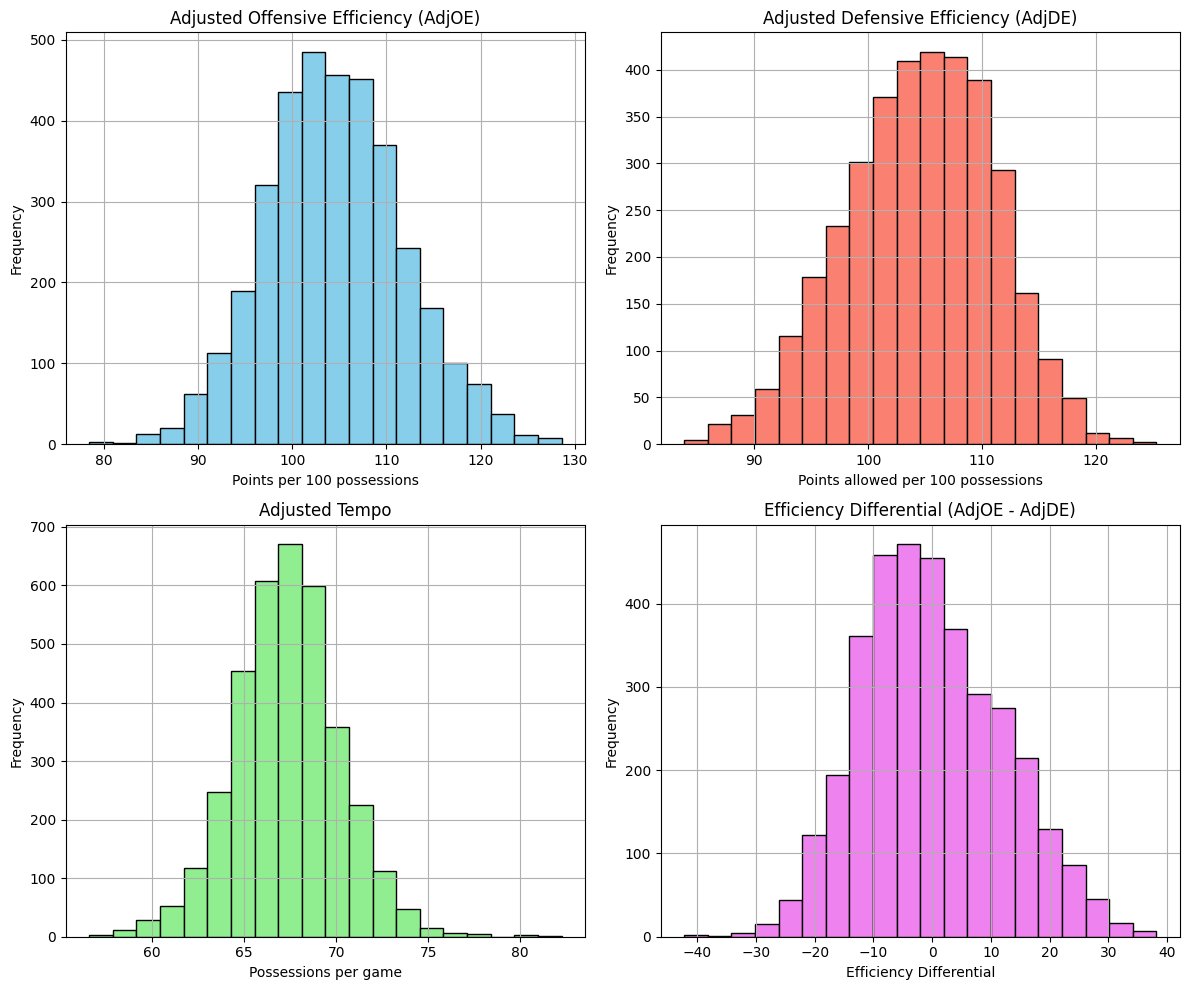

In [15]:
import matplotlib.pyplot as plt

# Set up a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram for Adjusted Offensive Efficiency
df['adj_off_eff'].hist(ax=axes[0,0], bins=20, color='skyblue', edgecolor='black')
axes[0,0].set_title('Adjusted Offensive Efficiency (AdjOE)')
axes[0,0].set_xlabel('Points per 100 possessions')
axes[0,0].set_ylabel('Frequency')

# Histogram for Adjusted Defensive Efficiency
df['adj_def_eff'].hist(ax=axes[0,1], bins=20, color='salmon', edgecolor='black')
axes[0,1].set_title('Adjusted Defensive Efficiency (AdjDE)')
axes[0,1].set_xlabel('Points allowed per 100 possessions')
axes[0,1].set_ylabel('Frequency')

# Histogram for Adjusted Tempo
df['adj_tempo'].hist(ax=axes[1,0], bins=20, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Adjusted Tempo')
axes[1,0].set_xlabel('Possessions per game')
axes[1,0].set_ylabel('Frequency')

# Histogram for Efficiency Differential
df['eff_diff'].hist(ax=axes[1,1], bins=20, color='violet', edgecolor='black')
axes[1,1].set_title('Efficiency Differential (AdjOE - AdjDE)')
axes[1,1].set_xlabel('Efficiency Differential')
axes[1,1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


## Observations from Initial Distributions

From the histograms, we can make several observations:

- **Adjusted Offensive Efficiency (AdjOE):**  
  Most conferences fall between ~100–115 points per 100 possessions,  
  with a few high-performing outliers above 120.  

- **Adjusted Defensive Efficiency (AdjDE):**  
  The majority of values are clustered between ~95–110,  
  with some conferences allowing higher points (>115).  

- **Adjusted Tempo:**  
  Most conferences average around 65–70 possessions per game.  
  A few faster-paced teams reach into the 75–80 range.  

- **Efficiency Differential (eff_diff):**  
  The distribution is centered near 0, showing balance between  
  offense and defense for many conferences.  
  However, some conferences have strongly positive values (dominant offense),  
  while others are negative (defense struggles relative to offense).  

These initial distributions suggest meaningful variation across seasons and conferences,  
which will help us explore comparative relationships in the next step.
